# 1. 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                        split = ['train', 'test'],
                                        shuffle_files = True,
                                        with_info = True)

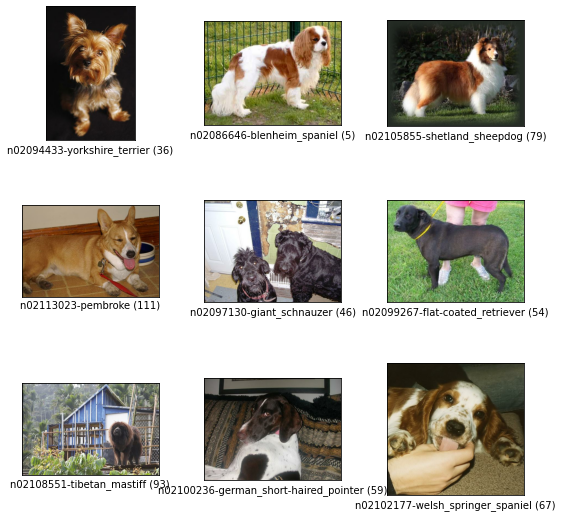

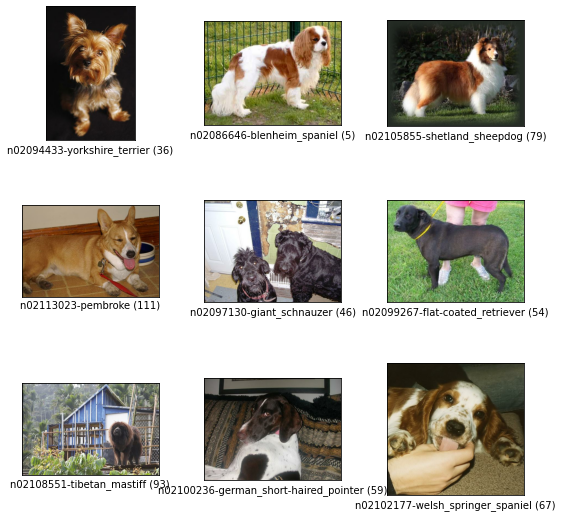

In [4]:
tfds.show_examples(ds_train, ds_info)

# 2. Augmentation 적용하기

### Tensorflow Random Augmentation API 사용하기

random_brightness(), random_contrast(), random_crop(), random_flip_left_right(), random_flip_up_down(), random_hue(),   
random_jpeg_quality(), random_saturation()

In [5]:
# 전처리

def normalize_and_resize_img(image, label):
    
    image = tf.image.resize(image,[224,224])
    
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# random_flip_left_right(), random_brightness()

def augment(image, label):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label



# random_flip_up_down(), random_contrast()

def augment2(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image,lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=2)
        
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

# 3. 비교실험 하기

-augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능 비교   
-모델은 ResNet 50을 쓸 예정이다

In [8]:
num_classes = ds_info.features['label'].num_classes


#include_top은 마지막 fully connected layer의 포함 여부. 해당 레이어를 포함하지 않고 생성 시 특정 추출기 부분만 불러와
#우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있다. 
resnet50 = keras.models.Sequential([
    
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')    
])

aug_resnet50 = keras.models.Sequential([
    
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [9]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, with_aug=False)

In [10]:
#EPOCHS = 20 은 해야 augmentation 적용 효과를 확인할 수 있으나 시간이 오래 걸리므로 여기서는 3만 하겠다.
EPOCHS = 3

resnet50.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.SGD(lr=0.01),
                metrics = ['accuracy'])

aug_resnet50.compile(loss = 'sparse_categorical_crossentropy',
                    optimizer = tf.keras.optimizers.SGD(lr=0.01),
                    metrics = ['accuracy'])

history_no_aug = resnet50.fit(ds_train_no_aug,
                             steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
                             validation_steps = int(ds_info.splits['test'].num_examples/16),
                             epochs = EPOCHS,
                             validation_data = ds_test,
                             verbose=1,
                             use_multiprocessing=True
                             )

history_with_aug = aug_resnet50.fit(ds_train_aug,
                             steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
                             validation_steps = int(ds_info.splits['test'].num_examples/16),
                             epochs = EPOCHS,
                             validation_data = ds_test,
                             verbose=1,
                             use_multiprocessing=True
                             )

Epoch 1/3
750/750 [==============================] - 364s 443ms/step - loss: 3.1855 - accuracy: 0.2815 - val_loss: 3.5808 - val_accuracy: 0.1716
Epoch 2/3
750/750 [==============================] - 324s 432ms/step - loss: 0.9633 - accuracy: 0.7372 - val_loss: 1.3166 - val_accuracy: 0.6263
Epoch 3/3
750/750 [==============================] - 354s 473ms/step - loss: 0.3478 - accuracy: 0.9196 - val_loss: 1.0047 - val_accuracy: 0.7024
Epoch 1/3
750/750 [==============================] - 327s 425ms/step - loss: 3.2498 - accuracy: 0.2677 - val_loss: 3.4981 - val_accuracy: 0.1848
Epoch 2/3
750/750 [==============================] - 320s 426ms/step - loss: 1.0916 - accuracy: 0.6952 - val_loss: 1.2185 - val_accuracy: 0.6359
Epoch 3/3
750/750 [==============================] - 318s 424ms/step - loss: 0.5624 - accuracy: 0.8461 - val_loss: 1.1781 - val_accuracy: 0.6658


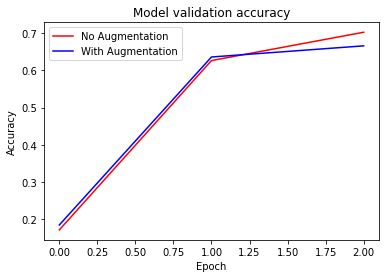

In [12]:
plt.plot(history_no_aug.history['val_accuracy'], 'r')
plt.plot(history_with_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

- 아무래도 EPOCH 수가 작아서 큰 효과를 보지는 못했지만 추후 프로젝트에서 해보자.